In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from numba import jit
import datetime
%matplotlib inline

# Read and clean data

This data is all hands played on each hour on the site

In [2]:
data = pd.read_csv('hourly_all_dummies.csv')
daily = pd.read_csv('daily_dummies.csv')
# Clean Daily dataset
daily = daily.drop('Unnamed: 0', 1)

In [3]:
data['Time'] = np.zeros(len(data))
data['Time^2'] = np.zeros(len(data))
data['Time*Treat'] = np.zeros(len(data))
data['Time*Treat^2'] = np.zeros(len(data))
data['lnHands'] = np.log(data['Hands'])
data['lnRake'] = np.log(data['Rake'])

In [4]:
for i in range(len(data)):
    data.loc[i, 'Time'] = i
    data.loc[i, 'Time*Treat'] = data.loc[i, 'Treat'] * (i - 1453)
    data.loc[i, 'Time^2'] = i**2
    data.loc[i, 'Time*Treat^2'] = data.loc[i, 'Treat'] * (i**2 - 1453)

# OLS

- Model on constant + dummies to test for intercept change

In [5]:
#
# OLS with quadratic time and interaction effects time* treat (and quad interaction)
#
X = data.loc[:, 'Treat':'Time*Treat^2']
X = sm.add_constant(X)
rake = data[['Rake']]
hands = data[['Hands']]
lograke = data[['lnRake']]
loghands = data[['lnHands']]

In [6]:
rake1 = sm.OLS(rake, X).fit()
#est1.summary()

In [7]:
hands1 = sm.OLS(hands, X).fit()
#est2.summary()

In [8]:
#
# OLS without quadratic time or time*treat
#
X2 = data.loc[:, 'Treat':'Time']
X2 = sm.add_constant(X2)
rake = data[['Rake']]
hands = data[['Hands']]
lograke = data[['lnRake']]
loghands = data[['lnHands']]
#minutes = data[['Minutes']]
#logminutes = data['logminutes']

In [9]:
hands2 = sm.OLS(hands, X2).fit()
#est3.summary()

In [10]:
rake2 = sm.OLS(rake, X2).fit()
#est4.summary()

In [11]:
lnrake2 = sm.OLS(lograke, X2).fit()
# est5.summary()

In [12]:
lnhands2 = sm.OLS(loghands, X2).fit()
# est6.summary()

# RDD

In [51]:
rddata = data.loc[1000:2000] #Cutoff is at 1453rd observation
rddaily = daily.loc[20:105] #Cutoff is at 62nd obs

rddata = rddata.reset_index()
rddata['index'] = rddata.index
rddaily = rddaily.reset_index()
rddaily['index'] = rddaily.index

In [52]:
rddata['index2'] = rddata['index']**2
rddata['index3'] = rddata['index']**3
rddata['treatIndex'] = rddata['index'] * rddata['Treat']
rddata['treatIndex2'] = rddata['index2'] * rddata['Treat']
rddata['treatIndex3'] = rddata['index3'] * rddata['Treat']

rddaily['index2'] = rddaily['index']**2
rddaily['index3'] = rddaily['index']**3
rddaily['treatIndex'] = rddaily['index'] * rddaily['Treat']
rddaily['treatIndex2'] = rddaily['index2'] * rddaily['Treat']
rddaily['treatIndex3'] = rddaily['index3'] * rddaily['Treat']

**Rake RDD**

In [75]:
rd_rake3_inter = smf.ols("Rake ~ Treat + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddata).fit()
rd_rake3 = smf.ols("Rake ~ Treat + index + index2 + index3", rddata).fit()
rd_rake3_inter_daily = smf.ols("Rake ~ Treat + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily).fit()
rd_rake3_daily = smf.ols("Rake ~ Treat + index + index2 + index3", rddaily).fit()
#rd_rake3_inter.summary()
#rd_rake3.summary()
#rd_rake3_inter_daily.summary()
#rd_rake3_daily.summary()

In [94]:
rd_rake2_inter = smf.ols("Rake ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit()
rd_rake2 = smf.ols("Rake ~ Treat + index + index2", rddata).fit()
rd_rake2_inter_daily = smf.ols("Rake ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily).fit()
rd_rake2_daily = smf.ols("Rake ~ Treat + index + index2", rddaily).fit()
#rd_rake2_inter.summary()
#rd_rake2.summary()
#rd_rake2_inter_daily.summary()
#rd_rake2_daily.summary()

**Hands RDD**

In [55]:
rd_hands2_inter = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddata).fit()
rd_hands2_inter_daily = smf.ols("Hands ~ Treat + index + index2 + treatIndex + treatIndex2", rddaily).fit()
#rd_hands2_inter.summary()
#rd_hands2_inter_daily.summary()

In [56]:
rd_hands3_inter = smf.ols("Hands ~ Treat + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddata).fit()
rd_hands3_inter_daily = smf.ols("Hands ~ Treat + index + index2 + index3 + \
                                 treatIndex + treatIndex2 + treatIndex3", rddaily).fit()
#rd_hands3_inter.summary()
#rd_hands3_inter_daily.summary()

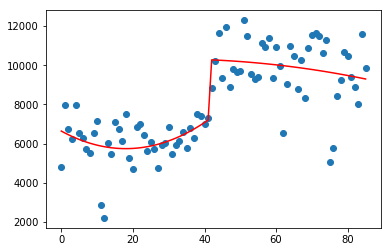

In [81]:
plt.scatter(rddaily['index'], rddaily['Rake'])
plt.plot(rd_rake2_inter_daily.fittedvalues, 'r')

# RD of 2nd cutoff

In [82]:
rddata2 = data.loc[2500:3500] #Cutoff is at 2960 observation
rddaily2 = daily.loc[85:155] #Cutoff is at 125nd obs

rddata2 = rddata2.reset_index()
rddata2['index'] = rddata2.index
rddaily2 = rddaily2.reset_index()
rddaily2['index'] = rddaily2.index

In [83]:
rddata2['index2'] = rddata2['index']**2
rddata2['index3'] = rddata2['index']**3
rddata2['treatIndex'] = rddata2['index'] * rddata2['Treat']
rddata2['treatIndex2'] = rddata2['index2'] * rddata2['Treat']
rddata2['treatIndex3'] = rddata2['index3'] * rddata2['Treat']

rddaily2['index2'] = rddaily2['index']**2
rddaily2['index3'] = rddaily2['index']**3
rddaily2['treatIndex'] = rddaily2['index'] * rddaily2['Treat']
rddaily2['treatIndex2'] = rddaily2['index2'] * rddaily2['Treat']
rddaily2['treatIndex3'] = rddaily2['index3'] * rddaily2['Treat']

**Rake RDD (2nd shock)**

In [87]:
after_rd_rake3_inter = smf.ols("Rake ~ After + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddata2).fit()
after_rd_rake3_inter_daily = smf.ols("Rake ~ After + + index + index2 + index3 +\
                                      treatIndex + treatIndex2 + treatIndex3", rddaily2).fit()
after_rd_rake3_daily = smf.ols("Rake ~ Treat + index + index2 + index3", rddaily2).fit()
#after_rd_rake3_inter.summary()
#after_rd_rake3_inter_daily.summary()
#after_rd_rake3_daily.summary()

In [61]:
after_rd_rake2_inter = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddata2).fit()
after_rd_rake2_inter_daily = smf.ols("Rake ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit()
#after_rd_rake2_inter.summary()
#after_rd_rake2_inter_daily.summary()

**Hands RDD (2nd shock)**

In [62]:
after_rd_hands2_inter = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddata2).fit()
after_rd_hands2_inter_daily = smf.ols("Hands ~ After + + index + index2 + treatIndex + treatIndex2", rddaily2).fit()
#after_rd_hands2_inter.summary()
#after_rd_hands2_inter_daily.summary()

In [63]:
after_rd_hands3_inter = smf.ols("Hands ~ After + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddata2).fit()
after_rd_hands3_inter_daily = smf.ols("Hands ~ After + + index + index2 + index3 + treatIndex + treatIndex2 + treatIndex3", rddaily2).fit()
#after_rd_hands3_inter.summary()
#after_rd_hands3_inter_daily.summary()

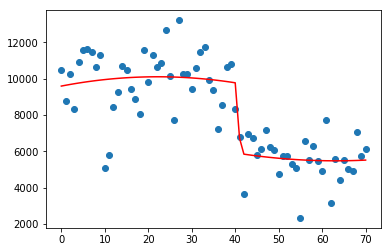

In [92]:
plt.scatter(rddaily2['index'], rddaily2['Rake'])
plt.plot(after_rd_rake2_inter_daily.fittedvalues, 'r')